# UPE Lunch & Learn PyTorch Demo

# Imports & Setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.utils.data import DataLoader

import torchvision
from torchvision.datasets import MNIST
from torchvision import transforms

from sklearn.metrics import balanced_accuracy_score as balanced_accuracy
from sklearn.metrics import accuracy_score as accuracy
from sklearn.metrics import classification_report

### Check Cuda Availability

In [2]:
cuda_available = torch.cuda.is_available()
print(f'CUDA Available: {cuda_available}')
if cuda_available:
    print(torch.cuda.get_device_name(0))

CUDA Available: True
Tesla T4


# Data Loading & Preprocessing

### Dataset Transforms

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),                                 # Transform images to tensors
    lambda image: image.view(image.size(1), image.size(2)) # Remove color channel dimension, since we only have black and white
])

### Getting the data, transforming, and loading it

In [4]:
mnist_train = MNIST(root="./", train=True, download=True, transform=transform)
mnist_test = MNIST(root="./", train=False, download=True, transform=transform)

train_loader = DataLoader(mnist_train, batch_size=10000, shuffle=True)
test_loader = DataLoader(mnist_test, batch_size=10000, shuffle=True)

### Example input

In [5]:
for images, labels in test_loader:
    sample_image = images[0]
    sample_label = labels[0]
    break

print(type(sample_image))
print(sample_image.shape)
print(sample_image)

<class 'torch.Tensor'>
torch.Size([28, 28])
tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.

### Example visual

tensor(9)


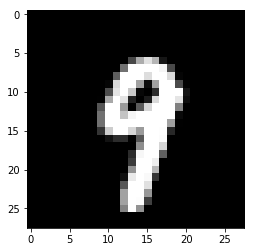

In [6]:
plt.imshow(sample_image, cmap="gray")

print(sample_label) # Label tensor
plt.show()

### Reshaping example

In [7]:
print(sample_image.shape)                                                    # Original shape
print(sample_image.view(sample_image.size(0)*sample_image.size(1)).shape)    # View to change shape
print(sample_image.reshape(sample_image.size(0)*sample_image.size(1)).shape) # Reshape to change shape
print(sample_image.flatten().shape)                                          # Flatten to change shape

torch.Size([28, 28])
torch.Size([784])
torch.Size([784])
torch.Size([784])


# Neural Network Model

In [8]:
class Model(nn.Module):
    # Model initialization
    def __init__(self):
        super(Model, self).__init__()
        
        self.hidden1 = nn.Linear(28*28, 100); # Hidden layers
        self.hidden2 = nn.Linear(100, 100); 
        self.hidden3 = nn.Linear(100, 100); 
        
        self.out = nn.Linear(100, 10); # Output layer
        
        self.relu = nn.ReLU();           # Hidden layer activation function
        self.softmax = nn.Softmax(dim=1) # Output layer activation function; All values in [0,1] and must sum to 1
        
    # Model operation
    def forward(self, x):
        h1 = self.relu(self.hidden1(x))
        h2 = self.relu(self.hidden2(h1))
        h3 = self.relu(self.hidden3(h2))
        return self.softmax(self.out(h3))

### Model Initialization

In [9]:
model = Model()
if cuda_available:
    model.cuda()

display(model)

Model(
  (hidden1): Linear(in_features=784, out_features=100, bias=True)
  (hidden2): Linear(in_features=100, out_features=100, bias=True)
  (hidden3): Linear(in_features=100, out_features=100, bias=True)
  (out): Linear(in_features=100, out_features=10, bias=True)
  (relu): ReLU()
  (softmax): Softmax()
)

### Training Initialization

In [10]:
counts = np.unique(mnist_train.targets, return_counts=True)[1] # Get number of occurrences of each label
weights = torch.from_numpy(np.max(counts)/counts).float() # get relative weights for each label
if cuda_available:
    weights = weights.cuda()
    
print(counts)
print(weights)

[5923 6742 5958 6131 5842 5421 5918 6265 5851 5949]
tensor([1.1383, 1.0000, 1.1316, 1.0997, 1.1541, 1.2437, 1.1392, 1.0761, 1.1523,
        1.1333], device='cuda:0')


In [11]:
criterion = nn.CrossEntropyLoss(weight=weights) # Loss function
optim = torch.optim.Adam(model.parameters(), lr=1e-3) # Optimizer function
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optim, factor=0.1, patience=5, verbose=True) # Scheduler function

# Model Training

### Defining training functions

In [12]:
# Train one epoch
def train():
    model.train() # Put model in training mode
    
    # Logging (note: this isn't particularly efficient, but it's nice to see)
    truths = []
    preds = []
    total_loss = 0.
    
    for x, y in train_loader:
        if cuda_available: # Move tensors over to cuda if present
            x = x.cuda()
            y = y.cuda()
        
        x = x.flatten(start_dim=1, end_dim=2) # Image in the loader is 28x28, but ur model expects a flattened image
        
        optim.zero_grad() # Reset gradients
        
        predictions = model(x) # Put data through model, get predictions
        
        loss = criterion(predictions, y) # Calculate loss (how wrong our predictions are)
        
        truths.extend(y.tolist()) # Add this batch's truths to the full list
        preds.extend(predictions.argmax(dim=1).tolist()) # Add this batch's predictions to the full list
        total_loss += loss.item() * predictions.size(0) # Add this batch's loss to the total loss (multiplied by this batch's size to account for size mismatches)
        
        loss.backward() # Calculate gradients
        optim.step() # Run optimizer & update weights and biases
         
    return total_loss/len(train_loader.dataset), accuracy(truths, preds), balanced_accuracy(truths, preds)


# Get validation (test) metrics
def test():
    model.eval() # Put model in evaluation mode
    
    truths = []
    preds = []
    total_loss = 0.
    
    for x, y in test_loader:
        if cuda_available:
            x = x.cuda()
            y = y.cuda()
        
        x = x.flatten(start_dim=1, end_dim=2)
        
        predictions = model(x) 
        
        loss = criterion(predictions, y)
        
        truths.extend(y.tolist()) 
        preds.extend(predictions.argmax(dim=1).tolist()) 
        total_loss += loss.item() * predictions.size(0) 
         
    return total_loss/len(test_loader.dataset), accuracy(truths, preds), balanced_accuracy(truths, preds)

### Training

In [13]:
epochs = 100
print_frequency = 5

In [14]:
train_losses = []
test_losses = []

train_accuracies = []
test_accuracies = []

train_balanced_accuracies = []
test_balanced_accuracies = []

for e in range(epochs):
    train_loss, train_accuracy, train_balanced_accuracy = train() # Train model
    test_loss, test_accuracy, test_balanced_accuracy = test() # Test model
    
    # Performance tracking
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)
    train_balanced_accuracies.append(train_balanced_accuracy)
    test_balanced_accuracies.append(test_balanced_accuracy)
    
    if (e+1) % print_frequency == 0:
        print('------------------------------------------------------------------------------------------------------------------------')
        print(f'Epoch: {e + 1}/{epochs}\t| Training Loss: {train_loss:.4f}\t| Training Accuracy: {train_accuracy:.4f}\t| Training Balanced Accuracy: {train_balanced_accuracy:.4f}')
        print(f'\t\t| Test Loss: {test_loss:.4f}\t| Test Accuracy: {test_accuracy:.4f}\t\t| Test Balanced Accuracy: {test_balanced_accuracy:.4f}')
                
    scheduler.step(test_loss)

print('------------------------------------------------------------------------------------------------------------------------')

------------------------------------------------------------------------------------------------------------------------
Epoch: 5/100	| Training Loss: 1.9959	| Training Accuracy: 0.6379	| Training Balanced Accuracy: 0.6286
		| Test Loss: 1.9067	| Test Accuracy: 0.6775		| Test Balanced Accuracy: 0.6684
------------------------------------------------------------------------------------------------------------------------
Epoch: 10/100	| Training Loss: 1.6186	| Training Accuracy: 0.8705	| Training Balanced Accuracy: 0.8685
		| Test Loss: 1.6021	| Test Accuracy: 0.8820		| Test Balanced Accuracy: 0.8798
------------------------------------------------------------------------------------------------------------------------
Epoch: 15/100	| Training Loss: 1.5666	| Training Accuracy: 0.9066	| Training Balanced Accuracy: 0.9054
		| Test Loss: 1.5619	| Test Accuracy: 0.9089		| Test Balanced Accuracy: 0.9076
-----------------------------------------------------------------------------------------

# Performance plots

### Training Performance

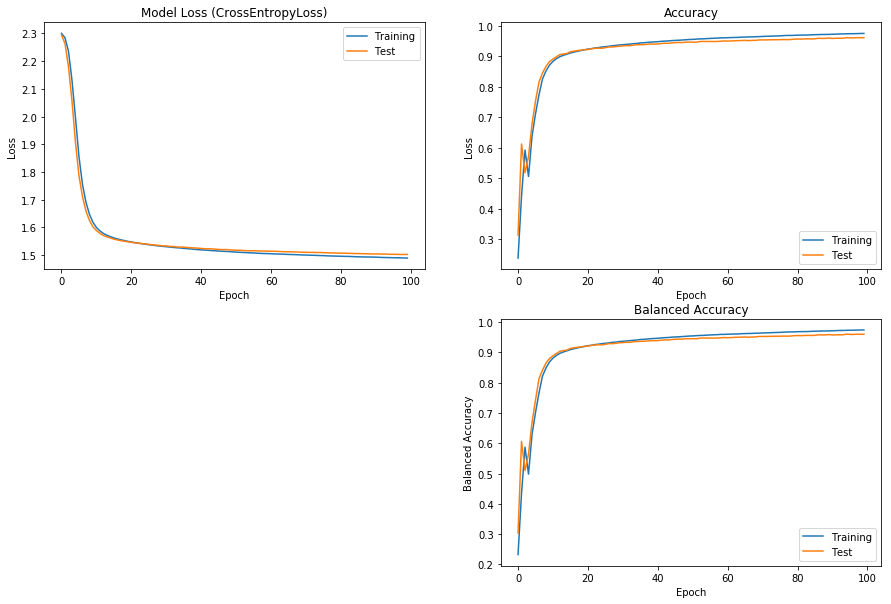

In [15]:
fig, axs = plt.subplots(2,2,figsize=(15,10))

# Loss
axs[0,0].plot(train_losses, label='Training')
axs[0,0].plot(test_losses, label='Test')
axs[0,0].legend()
axs[0,0].set_title(f'Model Loss ({criterion.__class__.__name__})')
axs[0,0].set_xlabel('Epoch')
axs[0,0].set_ylabel('Loss')

# Accuracy
axs[0,1].plot(train_accuracies, label='Training')
axs[0,1].plot(test_accuracies, label='Test')
axs[0,1].legend()
axs[0,1].set_title('Accuracy')
axs[0,1].set_xlabel('Epoch')
axs[0,1].set_ylabel('Loss')

# Balanced Accuracy
axs[1,1].plot(train_balanced_accuracies, label='Training')
axs[1,1].plot(test_balanced_accuracies, label='Test')
axs[1,1].legend()
axs[1,1].set_title('Balanced Accuracy')
axs[1,1].set_xlabel('Epoch')
axs[1,1].set_ylabel('Balanced Accuracy')

fig.delaxes(axs[1,0])

plt.show()